## Import 


In [1]:
# generic python imports
from itertools import count

# ML/math imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score, mutual_info_score

# pubmed processing imports
from Bio import Entrez
from bs4 import BeautifulSoup

# helper function for text processing
from helperfunctions import process_text

# drawing the topic distributions
from sklearn.manifold import TSNE
from gensim.matutils import sparse2full
from scipy.spatial.distance import pdist, squareform
from matplotlib import cm
from scipy.spatial import ConvexHull

Entrez.email = "suzana@capetownai.com"

## Download data

First download IDs of articles with different MESH categorisations, depending on the level of the tree.

First parameters are declared, then the IDs are acquired. Duplicates (articles with more than one MESH term) are removed, and then the data is subsampled and/or resampled as necessary.

In [2]:
LAYER = 1  # or 0, 2; the layer of MeSH tree to run this on
MAX_PER_MESH = 1000  # maximum number of articles per MeSH term

# as we go up the tree, search result counts will increase
# to contain everything in memory, we only look at the 
# `MAX_ARTICLES_QUERIED` return results
MAX_ARTICLES_QUERIED = 5000  # breaking point for number of articles queried from pubmed before filtering

MIN_ABSTRACT_LENGTH = 5  # handles edge cases where abstract is a single punctuation mark

In [3]:
labels = {}

labels[0] = [
    "Anatomy",
    "Organisms",
    "Diseases",
    "Chemicals and Drugs",
    "Analytical, Diagnostic and Therapeutic Techniques, and Equipment",
    "Psychiatry and Psychology",
    "Phenomena and Processes",
    "Disciplines and Occupations",
    "Anthropology, Education, Sociology, and Social Phenomena",
    "Technology, Industry, and Agriculture",
    "Humanities",
    "Information Science",
    "Named Groups",
    "Health Care",
    "Publication Characteristics",
    "Geographicals"
]

labels[1] = [
    "Physical Phenomena",
    "Chemical Phenomena",
    "Metabolism",
    "Cell Physiological Phenomena",
    "Genetic Phenomena",
    "Microbiological Phenomena",
    "Physiological Phenomena",
    "Reproductive and Urinary Physiological Phenomena",
    "Circulatory and Respiratory Physiological Phenomena",
    "Digestive System and Oral Physiological Phenomena",
    "Musculoskeletal and Neural Physiological Phenomena",
    "Immune System Phenomena",
    "Integumentary System Physiological Phenomena",
    "Ocular Physiological Phenomena",
    "Plant Physiological Phenomena",
    "Biological Phenomena",
    "Mathematical Concepts"
]

labels[2] = [
    "Bacterial Physiological Phenomena", 
    "Biofilms",
    "Catabolite Repression", 
    "Drug Resistance, Microbial", 
    "Germ-Free Life",
    "Hemadsorption",
    "Host Microbial Interactions",
    "Host-Pathogen Interactions",
    "Microbial Interactions",
    "Microbial Viability",
    "Microbiota",
    "Nitrogen Fixation",
    "Toxin-Antitoxin Systems",
    "Virus Physiological Phenomena",
    "Virulence"
]

In [4]:
retmax = 1000

# download article IDs
grouped_articles = {}
for i, mesh_term in enumerate(labels[LAYER]):
    all_article_ids = []
    for j in count():
        new_ids_list = Entrez.read(Entrez.esearch(
            db='pubmed', term=mesh_term, field='MESH', retmax=retmax,
            retstart=j*retmax
        ))['IdList']
        all_article_ids += new_ids_list
        if len(new_ids_list) < retmax:  # reached end of pagination
            break
        if len(all_article_ids) >= MAX_ARTICLES_QUERIED:
            break
    grouped_articles[mesh_term] = all_article_ids

# remove duplicates
for i, mesh_term1 in enumerate(labels[LAYER][:-1]):
    for mesh_term2 in labels[LAYER][i+1:]:
        term1_set = set(grouped_articles[mesh_term1])
        overlap = term1_set.intersection(grouped_articles[mesh_term2])
        for article_id in overlap:
            grouped_articles[mesh_term1].remove(article_id)
            grouped_articles[mesh_term2].remove(article_id)

In [5]:
# check the lengths of all the groups
print(
    *map(
        lambda x: ':\t'.join([x[0], str(len(x[1]))]),
        grouped_articles.items()
        ),
    sep='\n'
)

Bacterial Physiological Phenomena:	4055
Biofilms:	4676
Catabolite Repression:	397
Drug Resistance, Microbial:	4108
Germ-Free Life:	4961
Hemadsorption:	963
Host Microbial Interactions:	3836
Host-Pathogen Interactions:	3897
Microbial Interactions:	4653
Microbial Viability:	4926
Microbiota:	4810
Nitrogen Fixation:	4951
Toxin-Antitoxin Systems:	129
Virus Physiological Phenomena:	4683
Virulence:	4676


In [6]:
# prune articles to max count
for k in grouped_articles.keys():
    grouped_articles[k] = grouped_articles[k][:MAX_PER_MESH]

# create a dataframe of the articles
grouped_articles_reversed = dict()
for mesh_term, article_id_list in grouped_articles.items():
    grouped_articles_reversed.update(
        {article_id: mesh_term for article_id in article_id_list}
    )

In [7]:
# group the articles into a dataframe

df = pd.DataFrame.from_dict(
    grouped_articles_reversed,
    orient='index',
    columns=['mesh_term']
    )
df.reset_index(inplace=True)
df.rename(columns={"index": "pubmed_id"}, inplace=True)
df.head()

,pubmed_id,mesh_term
0,32393186,Bacterial Physiological Phenomena
1,32298803,Bacterial Physiological Phenomena
2,32251430,Bacterial Physiological Phenomena
3,32219545,Bacterial Physiological Phenomena
4,32216761,Bacterial Physiological Phenomena


In [8]:
# download the article abstracts from pubmed
# in fixed batch sizes


all_abstracts = []
batch_size = 1000
for i in range(0, df.shape[0], batch_size):
    print(
    f'Fetching articles {i} to {min(i + batch_size,df.shape[0])} of {df.shape[0]}'
    )
    all_articles_soup = BeautifulSoup(
        Entrez.efetch(
            db='pubmed',
            id=','.join(df.pubmed_id.iloc[i:i+batch_size]),
            retmode='xml'
        )
    )
    articles_split = all_articles_soup.find_all('pubmedarticle')
    articles = []
    for soup in articles_split:
        abstract = soup.find('abstract')
        if abstract:
            texts = [
                x.get_text(separator='')
                for x in abstract.find_all('abstracttext')
            ]
            articles.append('\n'.join(texts))
        else:
            articles.append('')
    all_abstracts += articles

df['abstract'] = [abstract.strip() for abstract in all_abstracts]
# normalise the near-empty abstracts to NaNs
nan_mask = df.abstract.apply(
    lambda x: len(x) < MIN_ABSTRACT_LENGTH
)
df.loc[nan_mask, 'abstract'] = np.nan
df.head()

Fetching articles 0 to 1000 of 10563
Fetching articles 1000 to 2000 of 10563
Fetching articles 2000 to 3000 of 10563
Fetching articles 3000 to 4000 of 10563
Fetching articles 4000 to 5000 of 10563
Fetching articles 5000 to 6000 of 10563
Fetching articles 6000 to 7000 of 10563
Fetching articles 7000 to 8000 of 10563
Fetching articles 8000 to 9000 of 10563
Fetching articles 9000 to 10000 of 10563
Fetching articles 10000 to 10563 of 10563


,pubmed_id,mesh_term,abstract
0,32393186,Bacterial Physiological Phenomena,IL-6 was associated with the severity of mycop...
1,32298803,Bacterial Physiological Phenomena,The coronavirus disease 19 (COVID-19) pandemic...
2,32251430,Bacterial Physiological Phenomena,Availability of good quality irrigation water ...
3,32219545,Bacterial Physiological Phenomena,This work describes the characterization and g...
4,32216761,Bacterial Physiological Phenomena,Tourniquets used for peripheral venous vascula...


## Process and topic model data

Here we lemmatise and topic model the data. Then we can ask what the  normalised mutual information looks like between the topics and the MeSH labels.

The topic modeling can take a few parameters, including a bias term which we could set to match the MeSH terms in the data.


In [9]:
# parameters
NUM_PASSES = 10  # epochs for the topic model fitting
USE_TOPIC_PRIOR = True
USE_WORD_PRIOR = False 

We can compare the custom `process_text` function with the other gensim-centric pipeline:
```
from helperfunctions import process_text, process_text_gensim

test_string = 'This is the story of a 1,3,7-trimethylxanthine-addicted 32-year-old girl.'
print(process_text(test_string, return_string=True))
print(process_text_gensim(test_string))
```
prints out:
```
story 137 trimethylxanthine addict year old girl
thi stori trimethylxanthin addict year old girl
```

In [10]:
tokenized_corpus = df.abstract[~df.abstract.isna()].apply(process_text)

In [11]:
id2word = Dictionary(tokenized_corpus)
bow_corpus = [
    id2word.doc2bow(token_list)
    for token_list in tokenized_corpus
]

In [12]:
alpha = 'symmetric'
if USE_TOPIC_PRIOR:
    alpha = df.mesh_term.value_counts().values.copy()
    alpha = alpha / alpha.sum()

eta = None
if USE_WORD_PRIOR:
    from gensim.matutils import corpus2dense
    eta = corpus2dense(bow_corpus, len(id2word)).sum(axis=0)
    eta = eta / eta.sum()

lda_model = LdaModel(
    corpus=bow_corpus,
    id2word=id2word,
    num_topics=df.mesh_term.nunique(),
    alpha=alpha,
    eta=eta,
    passes=NUM_PASSES
)

In [13]:
def get_dominant_topic(bow, return_prob=True):
    """Returns the topic with highest probability for input `bow`. 
    If `return_prob==True`, also returns the probability for the 
    corresponding topic.
    """
    topics = sorted(
        lda_model.get_document_topics(bow, minimum_probability=0.0),
        key=lambda x: x[1]
        )
    return topics[-1] if return_prob else topics[-1][0]

# we can only reasonably get the topics of non-empty documents
df['bow_length'] = 0.0
df['dominant_topic'] = np.nan
df.loc[~df.abstract.isna(), 'bow_length'] = [len(bow) for bow in bow_corpus]
dominant_topics = [
    get_dominant_topic(bow)
    for bow in bow_corpus
    if len(bow) > 0
    ]
dominant_topics = np.array(dominant_topics)
df.loc[df['bow_length'] > 0, 'dominant_topic'] = dominant_topics[:, 0]
df.loc[df['bow_length'] > 0, 'topic_probability'] = dominant_topics[:, 1]
# it helps to have the mesh terms be indices in the same range as the topics
# labels (mesh terms) are filtered because some labels may have no documents
labels_filtered = [l for l in labels[LAYER] if l in df.mesh_term.value_counts().index]
df['mesh_term_index'] = df.mesh_term.apply(
    labels_filtered.index
)

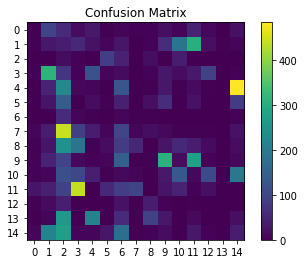

In [14]:
# Plot the confusion matrix of abstracts with computed topics
# against the MeSH terms
conf_mat = confusion_matrix(
    df.mesh_term_index[~df.dominant_topic.isna()],
    df.dominant_topic[~df.dominant_topic.isna()]
    )
plt.imshow(conf_mat)
plt.xticks(range(lda_model.num_topics))
plt.yticks(range(lda_model.num_topics))
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

## Compare topics and MeSH labels

Here we look at whether a match-up between the inferred topics and the assigned MeSH labels is better than random. We'll consider various different comparisons:
* `adjusted_rand_score`
* `normalized_mutual_info_score`
* `adjusted_mutual_info_score`
* `mutual_info_score`

Strictly speaking, this is p-hacking. We should choose a score and stick with it, instead of trying several while looking for a good p-value.

In [15]:
# parameters
NUM_RANDOM_ARRANGEMENTS = 10000
P_VALUE_PLOTS_FILENAME = f'p-value-plot-{LAYER}.png'
TSNE_PLOT_FILENAME = f'tsne-plot-{LAYER}.png'

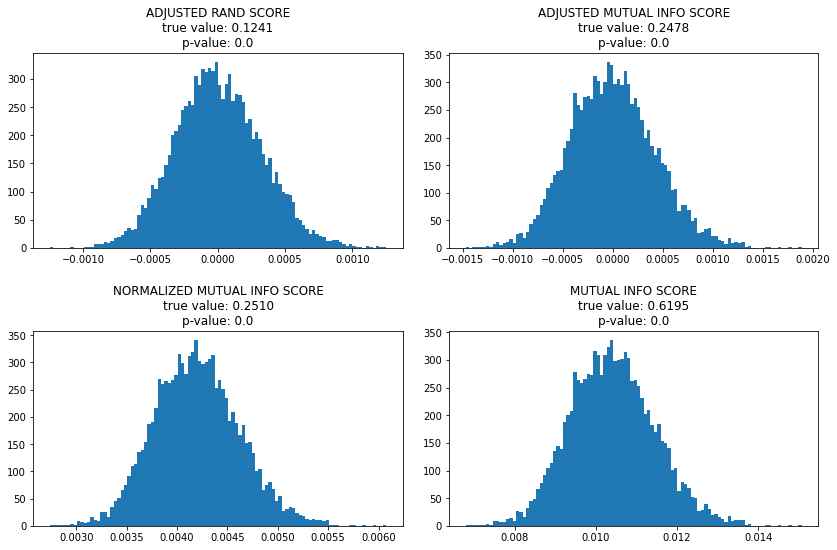

In [16]:
scores = [
    adjusted_rand_score,
    normalized_mutual_info_score,
    adjusted_mutual_info_score,
    mutual_info_score
    ]

mesh_labels = df.mesh_term_index[~df.dominant_topic.isna()]
dominant_topics = df.dominant_topic[~df.dominant_topic.isna()]
num_topics_or_labels = lda_model.num_topics

# Use the same bias in the topic model and mesh terms
# in the random sampling
random_arrangements = np.random.choice(
    a=lda_model.num_topics,  # chooses from np.arange(lda_model.num_topics)
    size=(len(mesh_labels), NUM_RANDOM_ARRANGEMENTS),
    p=alpha
    ) if USE_TOPIC_PRIOR else np.random.choice(
    a=lda_model.num_topics,
    size=(len(mesh_labels), NUM_RANDOM_ARRANGEMENTS)
    )

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, score in enumerate(scores):
    random_scores = []
    true_score = score(mesh_labels, dominant_topics)
    for sample_idx in range(NUM_RANDOM_ARRANGEMENTS):
        random_score = score(random_arrangements[:, sample_idx], dominant_topics)
        random_scores.append(random_score)
    # estimate p-value as probability that a random arrangement has a higher score
    p_val = (np.array(random_scores) > true_score).astype(int).sum() / NUM_RANDOM_ARRANGEMENTS
    axes[i % 2][int(i >= 2)].hist(random_scores, bins=int(np.sqrt(NUM_RANDOM_ARRANGEMENTS)))
    axes[i % 2][int(i >= 2)].set_title(
        score.__name__.replace('_', ' ').upper() \
        + '\n' + f'true value: {true_score:.4f}'\
        + '\n' + f'p-value: {p_val}'
        )

# if p-value == 0.0, then of all the random arrangments, NONE had a value
# higher than that of the true score. So the true p-value is estimated as
# less than 1 / NUM_RANDOM_ARRANGEMENTS == 1/10000

# true value = a measure of correlation between
# mesh label and topic assignments
fig.tight_layout(pad=2.0)

if P_VALUE_PLOTS_FILENAME is not None:
    fig.savefig(P_VALUE_PLOTS_FILENAME)

## Visualise MeSH and topic distributions

The topic vector representations for each document gives us a way to compare them and measure similarity. We can use this similarity to view t-SNE embedding of the documents, coloured by MeSH label, to see if the clustered documents match the mesh labels.

For extra clarity, we can optionally draw convex-hull-outlines around each topic.

We need to choose a distance metric for the t-SNE. This metric measures how far apart the points are in the original space, before the projection. Because the "points" in our case are topic _distributions_, I've set the metric to `'jensenshannon'` as the Jensen-Shannon metric is designed to measure a form of distance between distributions. All options can be found by interrogating the candidates for the `metric` parameter in the function `scipy.spatial.distance.pdist`.

We should also choose a perplexity score for t-SNE. Here I've set it to 5. Intuitively this captures the number of nearest neighbours that must be used in determining the embedded location of a point. A "low" perplexity (lower than 30, usually) usually suggests that clumping together of points happens on a very fine scale, while a "high" perplexity means clusters can get quite large. Too high a perplexity usually makes one big lump, which is why I set it quite low.

The observation that the topics vectors still clump together tells me that there isn't enough "information" (in a hand-wavy sense) in the topic distributions to separate them apart properly. 


In [17]:
# parameters
DRAW_CONVEX_HULL = False  # whether to draw convex hulls around topics

# t-SNE parameters
# Tried a few parameters here, they didn't seem to make
# much of a difference
TSNE_ITERATIONS = 3000  # number of iterations to fit t-SNE
TSNE_PERPLEXITY = 5  # perplexity, related to cluster size estimates
TSNE_METRIC = 'jensenshannon'  # metric for computing inter-topic-vector distance

In [18]:
def plot_hull(points, **plot_params):
    """Plots outlining hull. For more info, 
    see https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
    """    
    if 'color' not in plot_params:
        plot_params['color'] = 'black'
    
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], **plot_params)

In [19]:
topic_vectors = np.array([
    sparse2full(
        lda_model.get_document_topics(bow, minimum_probability=0.0),
        length=lda_model.num_topics)
    for bow in bow_corpus])
mesh_terms = df.mesh_term[~df.abstract.isna()]

tsne = TSNE(
    n_components=2,
    perplexity=TSNE_PERPLEXITY,
    metric='precomputed',
    n_iter=TSNE_ITERATIONS
)
distances = squareform(pdist(topic_vectors, metric=TSNE_METRIC))
embedded_points = tsne.fit_transform(distances)

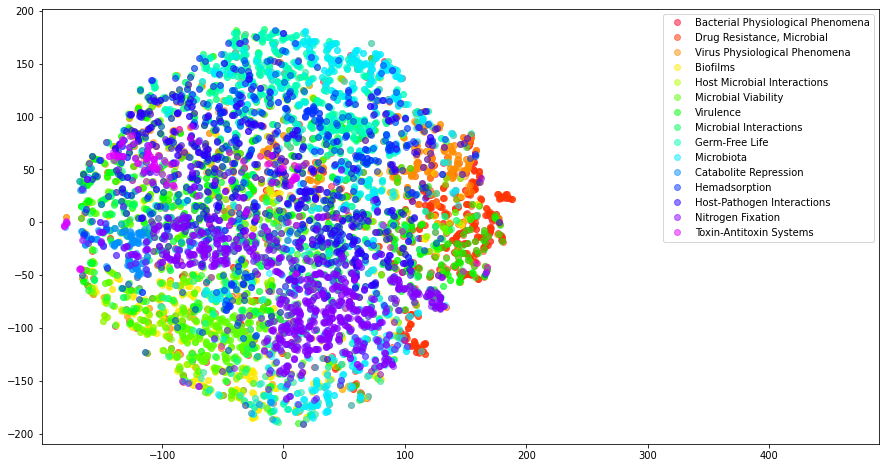

In [20]:
plt.figure(figsize=(15, 8))

for mesh_idx, mesh_term in enumerate(mesh_terms.unique()):
    mesh_points = embedded_points[mesh_terms == mesh_term]
    plt.plot(
        mesh_points[:, 0],
        mesh_points[:, 1],
        'o', color=cm.gist_rainbow(mesh_idx/mesh_terms.nunique()),
        label=mesh_term,
        alpha=0.8,
        ms=0.9
    )
    if DRAW_CONVEX_HULL:
        plot_hull(mesh_points, alpha=0.5)
# widen the plot to make space for the legend
plt.xlim([plt.xlim()[0], plt.xlim()[1] + 0.5*(plt.xlim()[1] - plt.xlim()[0])])
plt.legend(loc='upper right')
plt.title(f't-SNE topic vectors\nperplexity={TSNE_PERPLEXITY}')

if TSNE_PLOT_FILENAME is not None:
    plt.savefig(TSNE_PLOT_FILENAME)

plt.show()

## Save Data

In [21]:
df.to_csv(f'topic-modeled-abstracts-{LAYER}.csv')

____

## Supervised Learning Predictions of Label

Next we use generic machine learning methods to predict mesh labels from the individual abstracts. For simplicity, I'll use `TfidfVectorizer` from sklearn. This implements some preprocessing (such as stopword removal) which differs from what we've done above. We should be consistent with methods, which means going back and changing the method before or below.

It's very basic, and I don't use any GridSearch or other hyperparameter selection method. I also only implemented a few predictor models.

Things are reimported so that this section of cells can be run independently. After the imports, parameters are set and then the code is run.

In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

from keras.wrappers.scikit_learn import KerasClassifier

from nltk.corpus import stopwords

# TODO: add doc embedding preprocessing step

# helper function imports
from helperfunctions import process_text  # text preprocessing is here
import keras_model as km  # the Keras model is defined in this file

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time

In [2]:
# parameters

RANDOM_STATE = 0
NUM_CROSSVAL = 3
N_JOBS_CROSSVAL = -1  # number of CPUs used for crossvalidation. -1 => all
TEST_FRACTION = 0.3
LAYER = 1
FILTER_THRESHOLD = 0.0  # threshold for filtering by topic confidence

# keras params
NUM_EPOCHS_KERAS = 2  # number of epochs for Keras neural network
NLP_MODEL = 'en_core_sci_lg'  # model to populate Keras embedding layer with

# filenames
SCORES_FILENAME = f'scores-{LAYER}.csv'  # filename for model accuracies
CROSSVALIDATION_PLOT_FILENAME = f'pipeline-plot-{LAYER}.png'  # filename to save boxplot of pipeline results

## Load and filter data

In [4]:
df = pd.read_csv(f'topic-modeled-abstracts-{LAYER}.csv', index_col=0)
# filter away abstracts with low topic probability
df = df.loc[df.topic_probability >= FILTER_THRESHOLD]
df.head()

,Unnamed: 0.1,pubmed_id,mesh_term,abstract,bow_length,dominant_topic,topic_probability,mesh_term_index
0,0,32611859,Physical Phenomena,Use of silver diamine fluoride (SDF) after sel...,82.0,1.0,0.318294,0
1,1,32609100,Physical Phenomena,"It is estimated that, in the Netherlands, 20-3...",53.0,10.0,0.753903,0
2,2,32608945,Physical Phenomena,Clinical analysis of the effectiveness of phot...,44.0,9.0,0.257829,0
3,3,32608941,Physical Phenomena,To study the dynamics of changes in the adhesi...,73.0,6.0,0.606804,0
4,4,32584328,Physical Phenomena,"On January 23, 2020, China imposed a quarantin...",83.0,12.0,0.441819,0


In [5]:
# Here we create the training corpus and labels for cross validation

# split the test and training data
abstracts_train, abstracts_test, y_train, y_test = train_test_split(
    df.abstract[~df.abstract.isna()],
    df.mesh_term_index[~df.abstract.isna()],
    test_size=TEST_FRACTION,
    stratify=df.mesh_term_index[~df.abstract.isna()],
    shuffle=True,
    random_state=RANDOM_STATE
)

## Create Preprocessors

In [6]:
# set the parameters for the sklearn vectorizers
stoplist = stopwords.words('english')

vectorizer_params = dict(
    stop_words=stoplist,
    ngram_range=(1, 2)
)

In [7]:
from gensim.sklearn_api import Text2BowTransformer

# the defualt sklearn wrapper in gensim, `Text2BowTransformer`,
# returns the gensim BoW format rather than a numpy matrix
# so we need to extend the wrapper
from gensim.matutils import corpus2dense


class Text2BowTransformerExtension(Text2BowTransformer):
    '''Effectively this is a Gensim Dictionary, wrapped up to work 
    in a scikit-learn Pipeline with a custom text preprocessor. 
    It let's you use a custom tokenizer or text-preprocessing 
    function rather than the sklearn defaults.
    '''
    def transform(self, *args, **kwargs):
        result = super().transform(*args, **kwargs)
        return corpus2dense(result, len(self.gensim_model)).T

## Create Keras model

Most of the heavy lifting for creating the Keras model is in `keras_model.py`.

In [8]:
# Prepare the embedding layer
# This function creates the embedding layer with the (sci)spacy
# vectors, which is then shared across all folds of the 
# cross-validation.
# It also prepares the keras `Tokenizer` which is behind the scenes
# of the custom preprocessor `km.TokenizeAndPadTransformer`
km.prepare_embedding_layer(
    documents=df.abstract[~df.abstract.isna()],
    nlp_model=NLP_MODEL,
)

# Create the Keras preprocessor and predictor
output_dim = df.mesh_term_index.nunique()

keras_transformer = km.TokenizeAndPadTransformer()
keras_predictor = KerasClassifier(
    build_fn=km.create_model,
    output_dim=output_dim,
    epochs=NUM_EPOCHS_KERAS,
    batch_size=64,
    verbose=0
)
keras_predictor_lstm = KerasClassifier(
    build_fn=km.create_model_lstm,
    output_dim=output_dim,
    epochs=NUM_EPOCHS_KERAS,
    batch_size=64,
    verbose=0
)

In [9]:
preprocessors = dict(
    keras_transformer=keras_transformer,
    gensim=Text2BowTransformerExtension(tokenizer=process_text),
    count=CountVectorizer(**vectorizer_params),
    tfidf=TfidfVectorizer(**vectorizer_params),
)
predictors = dict(
    keras_predictor=keras_predictor,
    keras_predictor_lstm=keras_predictor_lstm,
    naive_bayes=MultinomialNB(alpha= 0.5, fit_prior=False),
    svm=SVC(C=1, kernel='linear',probability=True, class_weight='balanced',random_state=0), 
    logistic_regression=LogisticRegression(C= 1, max_iter = 100, penalty = 'l2',class_weight='balanced'),
    forest=RandomForestClassifier(max_depth=100, max_features=1000, min_samples_leaf=10,
                       n_estimators=300,class_weight='balanced',random_state=0)
)


cv_scores = {}
# Track scores to create dataframe
# NaN values are used to fill spaces where preprocessor and predictor did not match
scores_array = np.ones(shape=(len(preprocessors), len(predictors))) * np.nan
print('Evaluating pipelines:')
for i, prep in enumerate(preprocessors.items()):
    # each `prep` variable has the form (name, preprocessor)
    for j, predictor in enumerate(predictors.items()):
        # each `predictor` variable has the form (name, predictor)
        
        mean_score = np.nan
        # match up the keras transformer and predictor
        # they should be used together or skipped entirely
        if prep[0] == 'keras_transformer' and not predictor[0].startswith('keras'):
            continue
        elif predictor[0].startswith('keras') and not prep[0] == 'keras_transformer':
            continue
        
        n_jobs = N_JOBS_CROSSVAL
        if predictor[0].startswith('keras'):
            # keras won't let me share embedding layer across CPUs
            # so only one model can be trained at a time
            n_jobs = 1
        
        # create pipename for pretty reasons
        pipename = '->'.join([prep[0], predictor[0]])
        
        # combine `prep` and `predictor` into a pipeline
        pipeline = Pipeline(steps=[prep, predictor])
        print(f'[{pipename}]:\t', end=' ')
        
        # test the pipeline with cross-validation, and time it
        start_time = time()
        scores = cross_val_score(
            estimator=pipeline, X=abstracts_train, y=y_train,
            cv=NUM_CROSSVAL,
            n_jobs=n_jobs
            )
        end_time = time()
        
        # save scores
        mean_score = np.mean(scores)
        scores_array[i, j] = mean_score
        cv_scores[pipename] = scores
        print(f'runtime: {end_time-start_time:.2f}s\tmean score: {scores.mean()}')


Evaluating pipelines:
[keras_transformer->keras_predictor]:runtime: 167.01s	mean score: 0.40065789222717285
[keras_transformer->keras_predictor_lstm]:

## Save and show results

In [ ]:
# pickle file because it took so long to run
import pickle

with open('scores.pkl', 'wb') as file:
    pickle.dump(cv_scores, file)

In [ ]:
plt.figure(figsize=(15, 6))
plt.boxplot(cv_scores.values(), labels=cv_scores.keys())
plt.xticks(rotation=80)
plt.grid(ls=':')
plt.title('Pipeline Performances')
plt.ylabel('accuracy')

if CROSSVALIDATION_PLOT_FILENAME is not None:
    plt.savefig(CROSSVALIDATION_PLOT_FILENAME)

plt.show()

In [ ]:
# Finally, create dataframe of CV and test scores
scores_df = pd.DataFrame(
    scores_array,
    index=preprocessors.keys(),
    columns=predictors.keys())

scores_df.to_csv(SCORES_FILENAME)